## Notebook Info

In this notebook for the month of January we plot the mean methane concentration per latitude and longitude for the entire month. <br><br>
Plotting the mean: <br>
Some locations will have many data points for the month (good coverage) others will have few. Taking the mean is important to get a representative value, previously we were plotting all of the raw data which would plot the most recent recording at each position.

Exploring resolution: <br>
The raw TROPMOI latitude and longitude data is recorded at 4 decimal places which corresponds to a distance of 11.3 metres at the equator. <br> 
The resolution required for an informative plot of the entire earth is much less. The table below gives the distance resolution for different rounding precisions on latitude and longitude data. You can alter these in the code below, we go with round(0) for most of our plots.

Good website for information on earth data resolution : https://gisjames.wordpress.com/2016/04/27/deciding-how-many-decimal-places-to-include-when-reporting-latitude-and-longitude/ <br> 

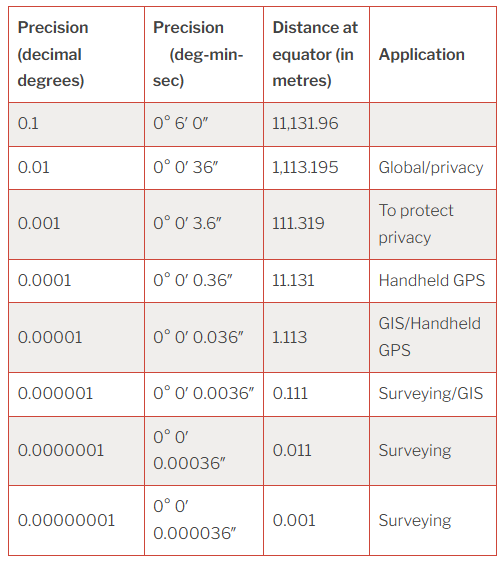



## Code

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd
from cartopy.io import shapereader
import glob
import pandas as pd

In [71]:
# Using round(0) which is rounding to the nearest whole number for lat and lon requires s = 40 on the plot <br>
# round(0) reduces number of data points on test day from ~ 55k to ~8.6k (111km grid resolution)<br>
# round (1) reduces data points from ~55k to ~30k (11km grid resolution) <br>

In [82]:
folder = '01' # 01 corresponds to January 

# Find all NetCDF files in the folder (this is all of the days of data
file_list = sorted(glob.glob('Data/' + folder + '/*.nc'))

# Initialize empty list to collect DataFrames
df_list = []

# Loop over each file
for f_name in file_list:
    ds = xr.open_dataset(f_name)

    # Extract variables
    lat = ds['latitude']
    lon = ds['longitude']
    xch4 = ds['xch4']

    # Mask invalid values
    valid = (xch4 > 0) & (~xch4.isnull())
    lat_valid = lat.where(valid, drop=True)
    lon_valid = lon.where(valid, drop=True)
    xch4_valid = xch4.where(valid, drop=True)


    lat_rounded = lat_valid.round(0)   # use 0 if coarse binning is okay; 1 or 2 if you want finer grouping (see table at the top of the notebook)
    lon_rounded = lon_valid.round(0)

    # Create DataFrame
    df = pd.DataFrame({
        'lat': lat_rounded.values,
        'lon': lon_rounded.values,
        'xch4': xch4_valid.values
    }).dropna()

    df_list.append(df)

# Concatenate all DataFrames
all_data = pd.concat(df_list, ignore_index=True)

# Group by (lat, lon) and calculate mean
mean_df = all_data.groupby(['lat', 'lon'], as_index=False).mean()

In [83]:
# Print the mean_df to see the mean data by latitude and longitude
mean_df

,lat,lon,xch4
0,-90.0,-164.0,1754.051392
1,-90.0,-160.0,1748.237549
2,-90.0,-156.0,1739.055786
3,-90.0,-155.0,1754.200073
4,-90.0,-144.0,1746.085571
...,...,...,...
27197,58.0,78.0,1900.672852
27198,58.0,79.0,1896.083740
27199,58.0,102.0,1922.774414
27200,58.0,103.0,1905.739624


### Plot January 2023 Mean data with nearest degree latitude and longitude resolution

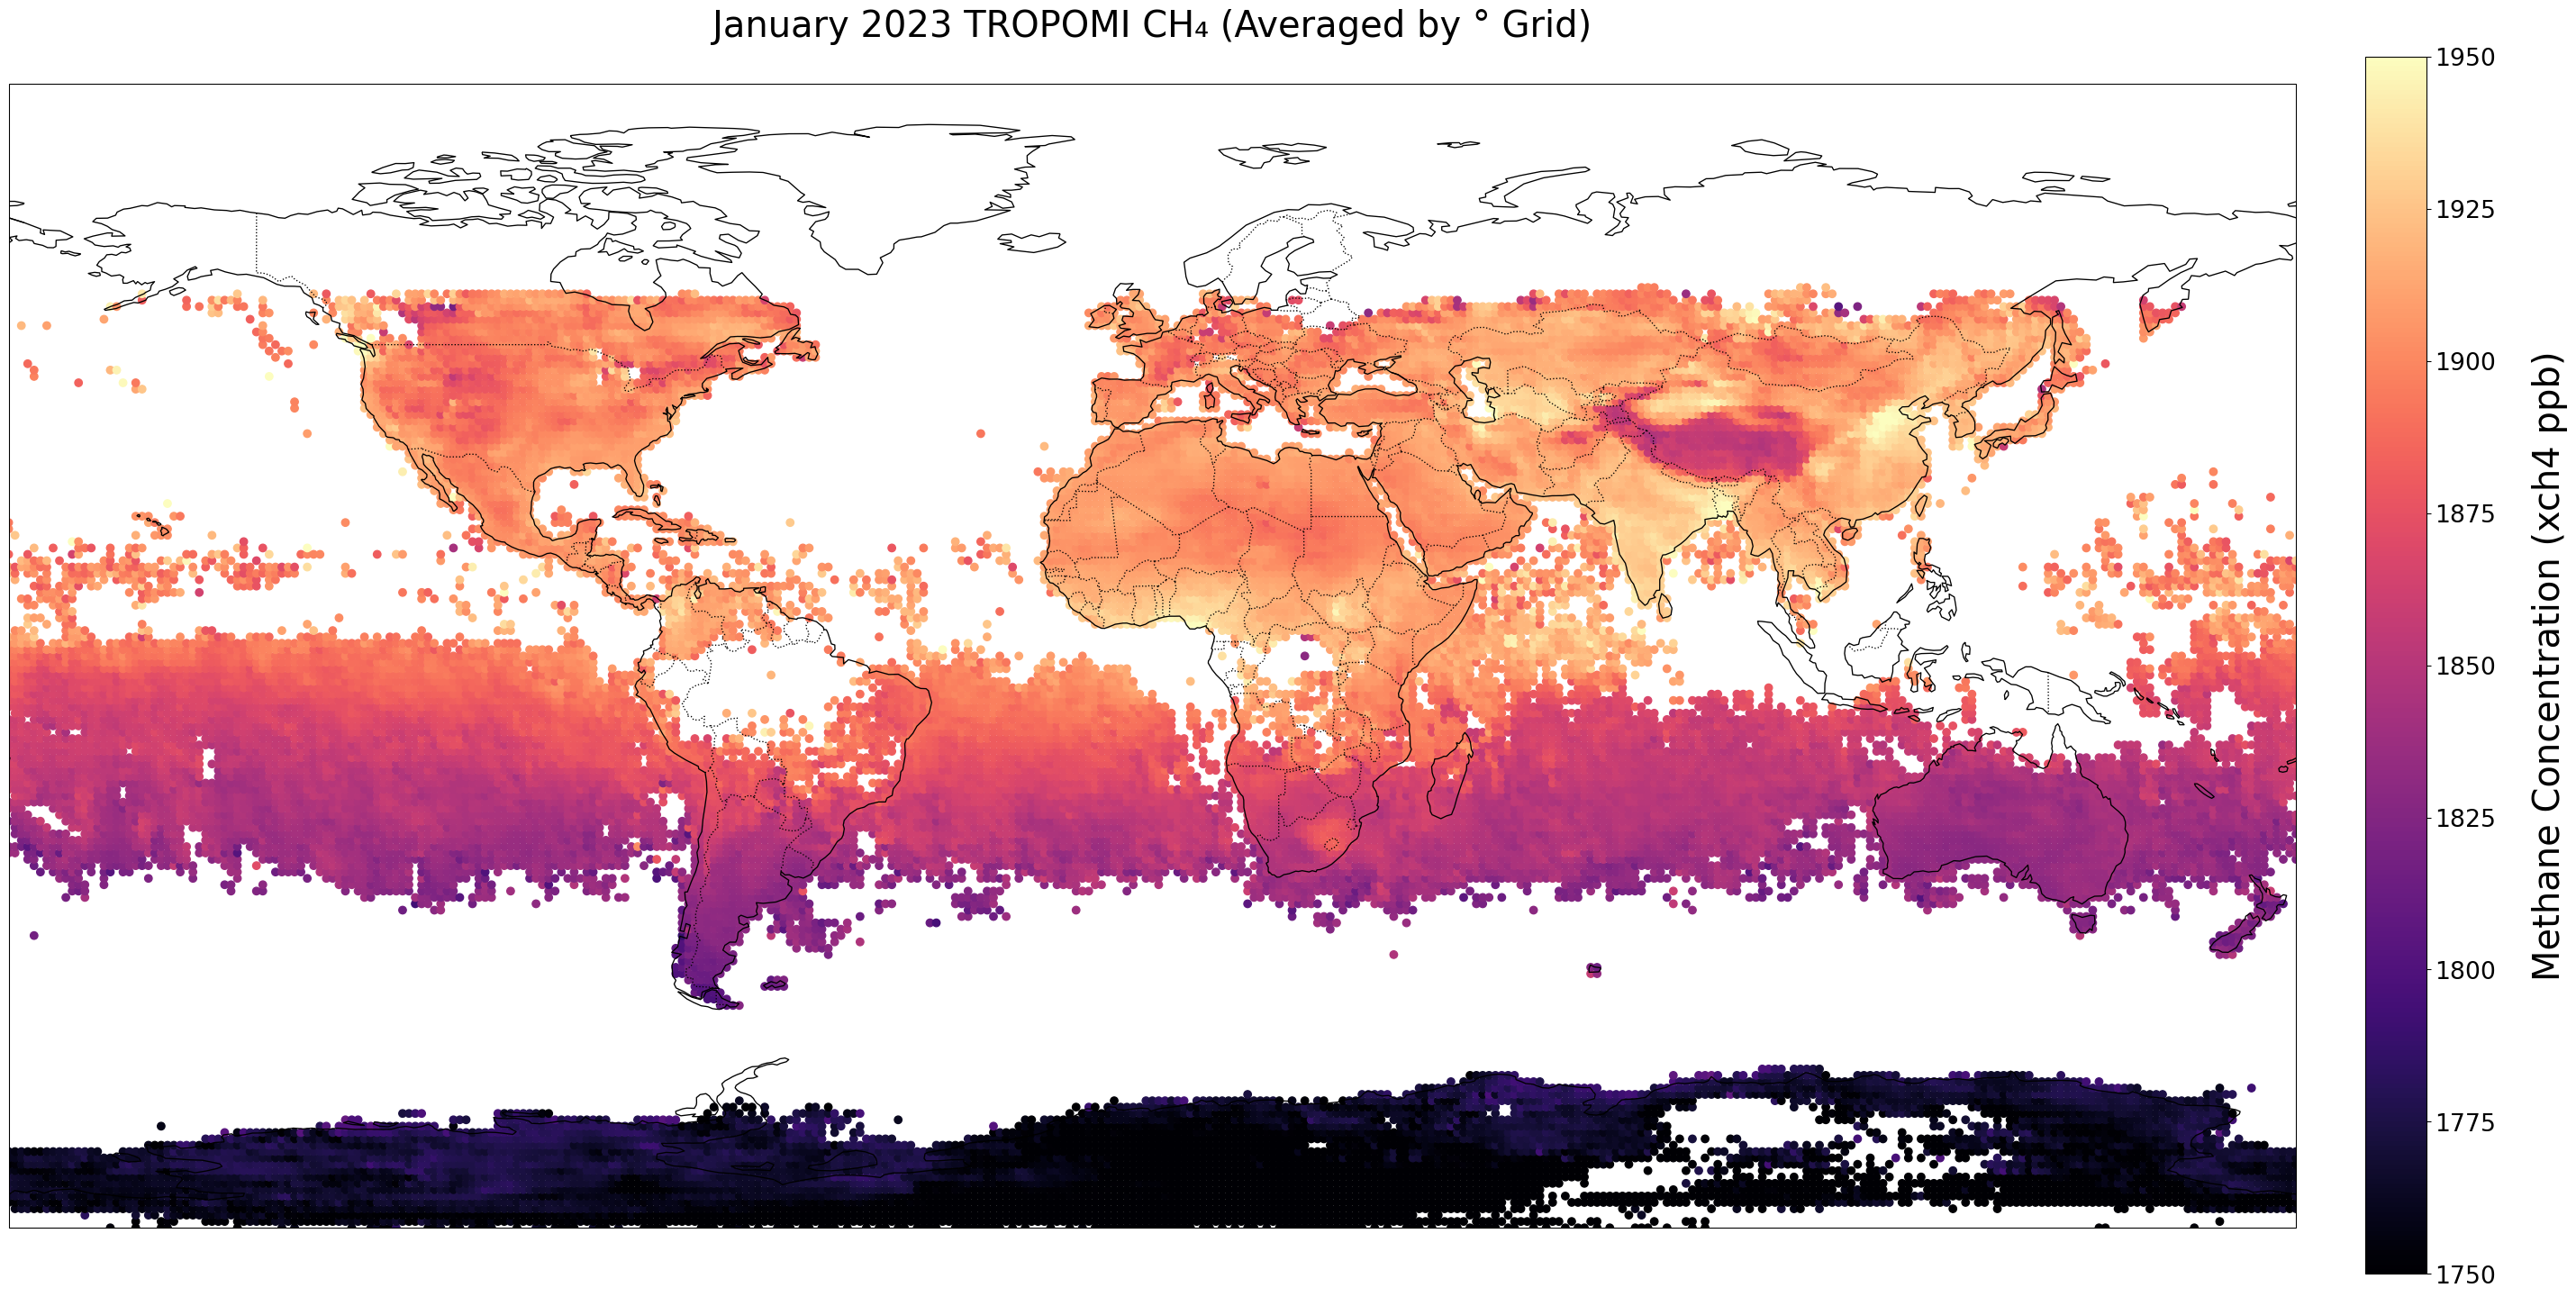

In [105]:
dpi = 96
width_in = 4096 / dpi
height_in = 2048 / dpi

#Set values for vmin and vmax 
min_val = 1750 
max_val = 1950

fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)

ax = plt.axes(projection=ccrs.PlateCarree())

sc = ax.scatter(
    mean_df['lon'], mean_df['lat'],
    c=mean_df['xch4'],
    s=40, # Adjust the point size relative to the lat / lon rounding and figure parameters (width, height , dpi)
    cmap="magma",
    transform=ccrs.PlateCarree(),
    vmin=min_val,  # Sets the minimum of the color scale
    vmax=max_val   # Sets the maximum of the color scale
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()

# Add colorbar
cbar = plt.colorbar(sc, pad=0.05)
cbar.ax.tick_params(labelsize=20)  # Change tick label font size
cbar.set_label('Methane Concentration (xch4 ppb)', fontsize=30 , labelpad = 30)

#Custom positioning - this code changes the positioning  & size of the colour bar slightly for a better looking figure
orig_pos = cbar.ax.get_position()
cbar.ax.set_position([orig_pos.x0 - 0.02 , orig_pos.y0 + 0.05, orig_pos.x1, orig_pos.y1*0.75])


plt.title("January 2023 TROPOMI CH₄ (Averaged by ° Grid)", size = 30 , pad = 40)

# plt.savefig('mean_figure_large_rounding_xLscatter_size.png', dpi = 96)
plt.show()